# DC GAN(Deep Convolutional GAN)

# Import Packages

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.layers import Reshape, Conv2D, Conv2DTranspose, Flatten, Activation
from keras.models import Model, Sequential

# 1. Load MNIST Dataset

- 'generator'의 'tanh' Activation 출력에 적합하도록 정규화

In [13]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalization
X_train = X_train.astype(np.float32) / 127.5 - 1

# Reshape
X_train = X_train.reshape(-1, 28, 28, 1)

# 2. 'adam' Optimizer 

- beta_1 : 감쇠율 조정

In [14]:
from keras.optimizers import Adam

adam = Adam(lr = 0.0002, beta_1 = 0.5)

# 3. 'generator' Model

- 랜덤 벡터(잠재공간의 랜덤 포인트)를 입력 받아 이미지 생성
   - noise_dim : 입력 랜덤 벡터 크기
- 'discriminator'를 속이도록 학습
   - 'Real Image'와 같은 'Fake Image' 생성이 목적적

In [25]:
noise_dim = 10

generator = Sequential(name = 'generator')  # 생성자 모델

generator.add(Dense(256 * 7 * 7, input_shape = (noise_dim,)))  # 10개의 noise data 들어감
generator.add(LeakyReLU())          # 12544
generator.add(Reshape((7, 7, 256))) # (14, 14, 128) 25088
generator.add(Conv2DTranspose(128, kernel_size = 3,
                              strides = 2,
                              padding = 'same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())          # (28, 28, 64) 50176
generator.add(Conv2DTranspose(64, kernel_size = 3,
                              strides = 2,
                              padding = 'same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())          # (28, 28, 1)
generator.add(Conv2D(1, kernel_size = 3,
                     padding = 'same'))
generator.add(Activation('tanh'))         # 레이어를 쌓아서 최종적으로 784개의 fake data 마만든다. 

- Model summary

In [26]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12544)             137984    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 64)        73

# 4. 'discriminator' Model

- 이미지를 입력 받아 'Real Image'인지 'generator'가 생성한 'Fake Image'인지 판별
   - 이진 분류

In [29]:
from tensorflow.keras.initializers import RandomNormal

discriminator = Sequential(name = 'discriminator')  # 생성자 모델

discriminator.add(Conv2D(32, kernel_size = 3,
                         strides = 2,
                         padding = 'same',
                         input_shape = (28, 28, 1)))  
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(64, kernel_size = 3,
                         strides = 2,
                         padding = 'same'))
discriminator.add(LeakyReLU())
discriminator.add(Conv2D(128, kernel_size = 3,
                         strides = 2,
                         padding = 'same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid'))  # 최종적으로 generator의 데이터가 진짜(1) or 가짜(0) 이진분류

- Model summary

In [30]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 4, 4, 128)       

> ## 1) 'discriminator' Compile

- 판별자 학습 설정

In [31]:
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = adam) 

# 5. 'gan' Model


> ## 1) 'generator', 'discriminator' 연결

- 'gan' 모델에서 'generator'만 학습하도록 설정
   - discriminator.trainable = False 

In [32]:
discriminator.trainable = False 

gan_input = Input(shape = (noise_dim,))  # generator의 input data(10개)를 초기에 넣고
x = generator(gan_input)                 # generator model로 10개를 학습
output = discriminator(x)                # 결과는 x를 generator로 학습시키고 discriminator로 학습시킨 결과를 말한다.

> ## 2) 'gan' Model

In [33]:
gan = Model(gan_input, output, name = 'gan') # 10개의 input data와 discriminator를 거친 output을 가진 모델 gan

> ## 3) 'gan' summary

In [34]:
gan.summary()

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
generator (Sequential)       (None, 28, 28, 1)         508161    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 94721     
Total params: 602,882
Trainable params: 507,777
Non-trainable params: 95,105
_________________________________________________________________


> ## 4) 'gan' Compile

- 학습 설정

In [35]:
gan.compile(loss = 'binary_crossentropy',
            optimizer = adam)

# 6. Difine 'get_batches( )' Function

- MNIST image batch 생성 : Real, Fake의 128차원을 더해서 이미지 생성 함수

In [36]:
def get_batches(data, batch_size):
    batches = []

    for i in range(data.shape[0] // batch_size):
        batch = data[i * batch_size : (i + 1) * batch_size]  
        batches.append(batch)
    return np.asarray(batches)
# data가 X_train이고 batch_size가 3이면, X_train에서 3개 만큼 뽑아서 batch라고 하고,
# 1개의 batch가 쌓이고 쌓이면 batches가 되고, batches를 array만들어서 출력

# 7. 'visualize_training( )' Function

In [37]:
def visualize_training(epoch, d_losses, g_losses):
    
    # 오차 시각화
    # plt.figure(figsize = (8, 4))
    # plt.plot(d_losses, label = 'Discriminator Loss')
    # plt.plot(g_losses, label = 'Generator Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()
    # print('epoch : {}, Discriminator Loss : {}, Generator Loss : {}'.format(epoch, np.asarray(d_losses, g_losses)))

    # 이미지 생성 결과 시각화
    print('epoch : ', epoch)
    noise = np.random.normal(0, 1, size = (24, noise_dim))  # 0 ~ 1의 정규 랜덤 수들이 24행 10열
    generated_images = generator.predict(noise)             # noise의 data로 생성자를 거쳐서 784개의 fake 나온다.
    generated_images = generated_images.reshape(-1, 28, 28) # 784개를 1차원에서 2차원으로 바꾼다

    plt.figure(figsize = (8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i + 1)
        plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 8. Define Loss

In [ ]:
# loss_function = keras.losses.BinaryCrossentropy()
# train_loss = keras.metrics.BinaryCrossentropy(name = 'train_loss')
# train_accuracy = keras.metrics.BinaryAccuracy(name = 'train_accuracy')

# 9. Model Training

- 약 25분
- .fit( ) 
   - 'epoch', 'batch_size' 지정
- .train_on_batch( )
   - 전달 받을 모든 데이터를 사용하여 학습 진행
- 'generator'가 매번 새로운 'Fake Image'를 생성하여 '.train_on_batch( )' 사용

epoch :  1


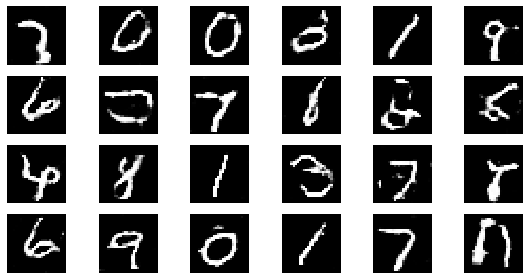

epoch :  5


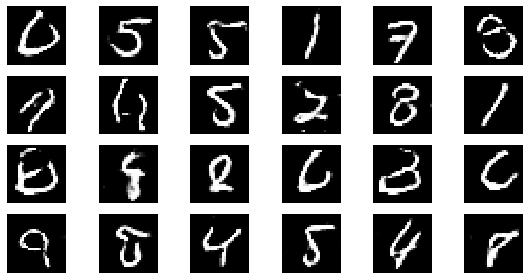

epoch :  10


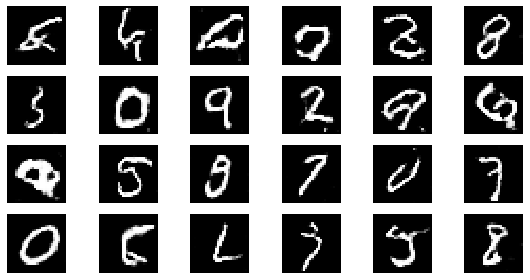

epoch :  15


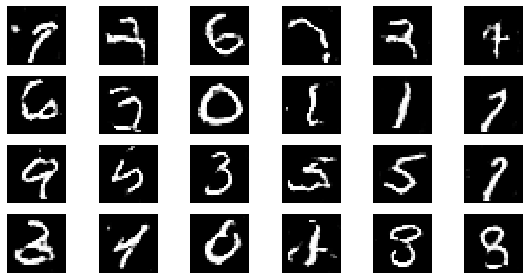

epoch :  20


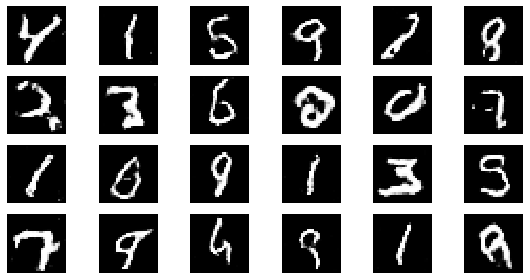

epoch :  25


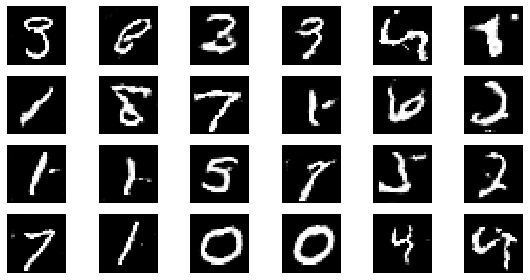

epoch :  30


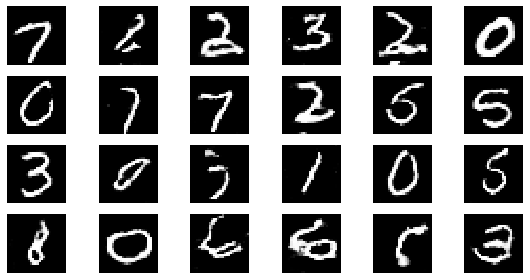

epoch :  35


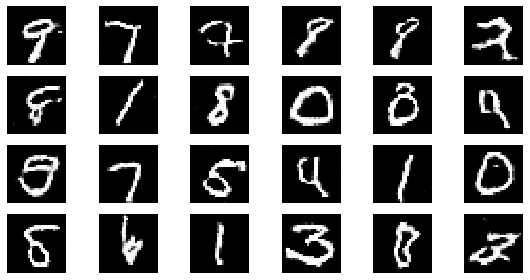

epoch :  40


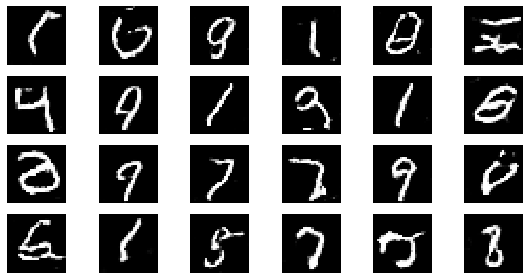

epoch :  45


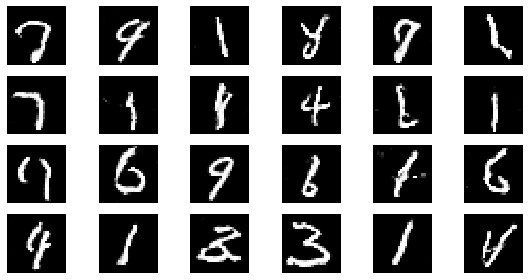

epoch :  50


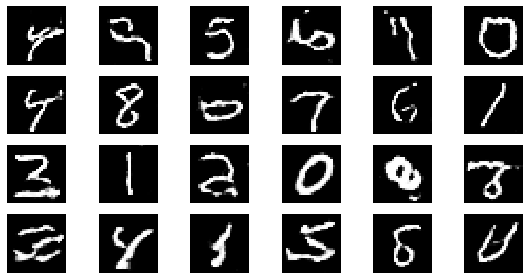

CPU times: user 20min 15s, sys: 1min 15s, total: 21min 30s
Wall time: 24min 50s


In [39]:
%%time

epochs = 50      # 총 100번 돌린다
batch_size = 128  # real, fake에서 128개씩 가져와서

# 'discriminator', 'gan' Loss 저장 List
d_losses = []
g_losses = []

for epoch in range(1, epochs + 1):
  # batch 별 학습
  for real_images in get_batches(X_train, batch_size):   # X_train을 128개만큼 뽑아 이게 real data임  
    # Random Noise 생성
    input_noise = np.random.uniform(-1, 1, size = [batch_size, noise_dim]) # 뽑아온 batch_size에서 랜덤하게 뽑기 위해 random.uniform

    # Fake Image 데이터 생성
    generated_images = generator.predict(input_noise)    # input_noise를 생성자를 통해 학습 시킨 fake data

    # 'gan' 학습용 X 데이터 정의
    x_dis = np.concatenate([real_images, generated_images]) # real(128개)아래에 fake(128개)를 붙여 행렬을 만들어

    # 'gan' 학습용 y 데이터 정의 : 레이블 지정
    y_dis = np.zeros(2 * batch_size)   # batch_size의 왜 두배? real, fake 128개씩 가져오니까 128개의 두배, x_dis의 행 길이만큼의 길이   
    y_dis[: batch_size] = 1            # 앞의 128개 데이터에는 1(real)을 부여, 나머지 128개에 0(fake)을 부여

    # 'discriminator' 학습
    discriminator.trainable = True     # real, fake를 판별 할 일만 남았으니 판별자를 학습 가능하게 freeze 풀어주고,
    d_loss = discriminator.train_on_batch(x_dis, y_dis) # 판별을 진행해서 생성자한테 속은 학습(fake를 real이라고 판단)은 d_loss라고 한다.

    # 'gan' 학습
    noise = np.random.uniform(-1, 1, size = [batch_size, noise_dim])
    y_gan = np.ones(batch_size)        # batch_size만큼 1로 채움 ???

    # 'discriminator' 학습 정지
    discriminator.trainable = False   # 판별자를 학습한 후에는 다시 판별자 freeze 
    g_loss = gan.train_on_batch(noise, y_gan) # 판별자가 맞게 판별한 데이터를 판별자가 틀리게 하기 위해 다시 생성자가 학습

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  # 생성 결과 시각화
  if epoch == 1 or epoch % 5 == 0:
    visualize_training(epoch, d_losses, g_losses)  # 처음엔 숫자 형태가 아니었지만 점점 숫자를 띄는 것을 볼 수 있다

###
# The End
###